In [1]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
#     * Bar graph: Fines per year before and after Trump
#     * Scatter plot 
#     * Map cities with most deficiencies QGIS

In [3]:
!ls

Nursing Homes in Texas.ipynb        nursinghomes2.pdf
README.md                           nursinghomes4.pdf
finesunderTrump.csv                 nursinghomes5.pdf
images                              penaltiestest.xlsx
index.html                          scatterplot.pdf
inspection reports per facility.csv simple.html
nursing homes penalties.csv         styles
nursinghomes1.pdf


### Filter Texas Deficiencies

In [4]:
df2 = pd.read_csv("inspection reports per facility.csv")

texas_deficiencies = df2[(df2['state'] == 'TX')]
texas_deficiencies.head()

,facility_name,facility_id,address,city,state,zip,inspection_date,deficiency_tag,scope_severity,complaint,standard,eventid,inspection_text
17739,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,12/08/2016,441,E,1,0,51U811,"><BR/>Based on observation, interview, and rec..."
17740,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,12/08/2016,498,E,1,0,51U811,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17741,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,224,E,1,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17742,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,226,E,1,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17743,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,248,E,0,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...


In [5]:
deficiency_count = texas_deficiencies.pivot_table(columns=['scope_severity'],
                               index=['facility_name'],
                               aggfunc='count', fill_value=0).drop(['address',
                                          'city',
                                          'state',
                                          'zip',
                                          'inspection_date',
                                          'deficiency_tag',
                                          'complaint', 
                                          'standard', 
                                          'inspection_text', 
                                          'inspection_date',
                                          'eventid'], axis=1)
deficiency_count.head()

facility_id                  \
scope_severity                                             B  C  D   E  F  G   
facility_name                                                                  
ACCEL AT COLLEGE STATION                                   0  0  1   1  1  0   
ACCEL AT WILLOW BEND                                       0  0  6   6  8  2   
ADVANCED HEALTH & REHAB CENTER OF GARLAND                  0  0  4  13  4  0   
ADVANCED REHABILITATION & HEALTHCARE OF LIVE OAK           0  1  2  39  3  0   
ADVANCED REHABILITATION AND HEALTHCARE OF BOWIE            0  1  0  10  3  0   

                                                                 
scope_severity                                    H  I  J  K  L  
facility_name                                                    
ACCEL AT COLLEGE STATION                          0  0  0  0  0  
ACCEL AT WILLOW BEND                              0  0  0  0  0  
ADVANCED HEALTH & REHAB CENTER OF GARLAND         0  0  0  0  0  
ADVANCED REHABILITATION & HEALTHCARE OF LIVE OAK  0  0  0  0  0  
ADVANCED REHABILITATION AND HEALTHCARE OF BOWIE   0  0  0  0  0

### Find facilities with most serious deficiencies

In [6]:
deficiency_count = deficiency_count['facility_id'].astype(str).drop(['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], axis=1)

In [7]:
deficiency_count.head()

scope_severity,J,K,L
facility_name,,,
ACCEL AT COLLEGE STATION,0,0,0
ACCEL AT WILLOW BEND,0,0,0
ADVANCED HEALTH & REHAB CENTER OF GARLAND,0,0,0
ADVANCED REHABILITATION & HEALTHCARE OF LIVE OAK,0,0,0
ADVANCED REHABILITATION AND HEALTHCARE OF BOWIE,0,0,0


In [8]:
deficiency_count['K'] = deficiency_count['K'].astype(int)
deficiency_count['J'] = deficiency_count['J'].astype(int)
deficiency_count['L'] = deficiency_count['L'].astype(int)

In [9]:
deficiency_count['sum'] = deficiency_count['J'] + deficiency_count['K'] + deficiency_count['L']

In [10]:
most_deficiencies = deficiency_count[(deficiency_count['sum'] > 7)].sort_values(by='sum', ascending=False).reset_index()

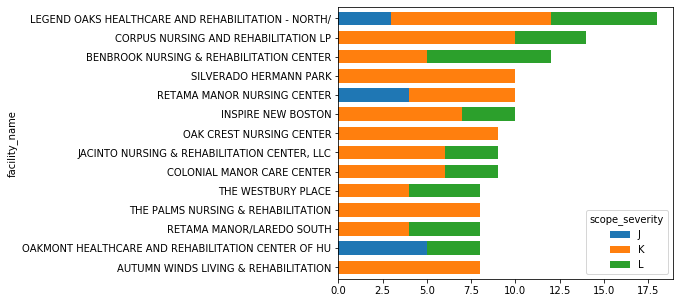

In [11]:
most_deficiencies.sort_values(by='sum').plot(x='facility_name', 
                                             y=['J', 'K', 'L'], 
                                             kind='barh',
                                             figsize=(6, 5),
                                             width=0.7,
                                             stacked=True, 
                                             title='')
plt.savefig('nursinghomes1.pdf')

## Find total number of fines before and after Trump

In [12]:
texas_fines = pd.read_csv("nursing homes penalties.csv")

In [13]:
texas_fines.dtypes

provnum        int64
provname      object
address       object
city          object
zip            int64
pnlty_date    object
pnlty_type    object
fine_amt      object
dtype: object

### Drop the outlier from 2017 Q4

In [14]:
# texas_fines.loc[texas_fines['fine_amt'] == '1,254,213']
texas_fines = texas_fines.drop([894])

## Build dataframe of fines per quarter

In [15]:
df = pd.DataFrame(columns=['2014 Q1', '2014 Q2', '2014 Q3', '2014 Q4', 
                           '2015 Q1', '2015 Q2', '2015 Q3', '2015 Q4',
                           '2016 Q1', '2016 Q2', '2016 Q3', '2016 Q4',
                           '2017 Q1', '2017 Q2', '2017 Q3', '2017 Q4',
                           '2018 Q1', '2018 Q2', '2018 Q3', '2018 Q4',], index=['0'])

In [16]:
texas_fines['fine_amt'] = texas_fines['fine_amt'].str.replace(',', '', regex=True).astype(int)

In [17]:
df['2014 Q1'] =texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/14'))].fine_amt.sum()
df['2014 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/14'))]['fine_amt'].sum()
df['2014 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/14'))]['fine_amt'].sum()
df['2014 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/14'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/14'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/14'))]['fine_amt'].sum()

/Users/elenamlutz/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [18]:
df['2015 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/15'))]['fine_amt'].sum()
df['2015 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/15'))]['fine_amt'].sum()
df['2015 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/15'))]['fine_amt'].sum()
df['2015 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/15'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/15'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/15'))]['fine_amt'].sum()

In [19]:
df['2016 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/16'))]['fine_amt'].sum()
df['2016 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/16'))]['fine_amt'].sum()
df['2016 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/16'))]['fine_amt'].sum()
df['2016 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/16'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/16'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/16'))]['fine_amt'].sum()

In [20]:
df['2017 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/17'))]['fine_amt'].sum()
df['2017 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/17'))]['fine_amt'].sum()
df['2017 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/17'))]['fine_amt'].sum()
df['2017 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/17'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/17'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/17'))]['fine_amt'].sum()

In [21]:
df['2018 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/18'))]['fine_amt'].sum()
df['2018 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/18'))]['fine_amt'].sum()
df['2018 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/18'))]['fine_amt'].sum()
df['2018 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/18'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/18'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/18'))]['fine_amt'].sum()

In [22]:
df['2019 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/19'))]['fine_amt'].sum()

In [23]:
df.head()

,2014 Q1,2014 Q2,2014 Q3,2014 Q4,2015 Q1,2015 Q2,2015 Q3,2015 Q4,2016 Q1,2016 Q2,...,2016 Q4,2017 Q1,2017 Q2,2017 Q3,2017 Q4,2018 Q1,2018 Q2,2018 Q3,2018 Q4,2019 Q1
0,863013,1005131,603364,606628,1344473,1396415,1391959,395146,1431867,1657746,...,738357,3463691,2973784,2257091,2037198,1879890,1753428,1165449,1061677,1702645


In [24]:
df = df.stack().reset_index().drop(['level_0'], axis=1).rename(columns={'level_1': 'Quarter',
                                                                        0: 'Total Fines'})

In [25]:
#df.to_csv('finesunderTrump.csv')

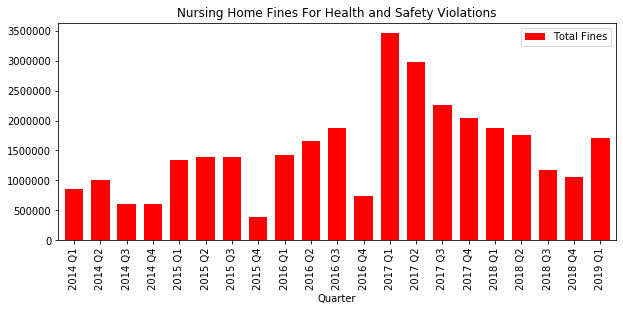

In [26]:
df.plot(x='Quarter',
        y=['Total Fines'],
        color='red',
        kind='bar',
        figsize=(10, 4),
        width=0.7,
        title='Nursing Home Fines For Health and Safety Violations')

plt.savefig('nursinghomes2.pdf')

## Find facilities with highest number of complaints

In [27]:
texas_deficiencies['complaint'] = texas_deficiencies.complaint.replace({1: 'yes', 0: 'no'})

/Users/elenamlutz/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
texas_complaints = texas_deficiencies[(texas_deficiencies['complaint']=='yes')]

In [29]:
texas_complaints = pd.DataFrame(texas_complaints.facility_name.value_counts().head(15))

In [30]:
texas_complaints=texas_complaints.reset_index()

In [31]:
texas_complaints=texas_complaints.rename(columns={'index': 'provname',
                                                  'facility_name': 'complaints'})
texas_complaints.head()

,provname,complaints
0,KENNEDY HEALTH & REHAB,52
1,THE WESTBURY PLACE,50
2,BRIARCLIFF NURSING AND REHABILITATION CENTER,48
3,OAK PARK NURSING AND REHABILITATION CENTER,46
4,CHELSEA GARDENS,46


In [32]:
texas_complaints['provname'] = texas_complaints['provname'].str.strip()

In [33]:
texas_fines.head()

,provnum,provname,address,city,zip,pnlty_date,pnlty_type,fine_amt
0,455497,CREEKSIDE TERRACE REHABILITATION,1555 POWELL AVENUE,BELTON,76513,1/2/15,Fine,5525
1,675056,STANTON NURSING AND REHABILITATION LP,1100 W BROADWAY,STANTON,79782,1/8/15,Fine,7670
2,455678,SUMMER MEADOWS,301 HOLLYBROOK DR,LONGVIEW,75605,1/15/15,Fine,1268
3,675501,HERITAGE OAKS WEST RETIREMENT VILLAGE,3300 W 2ND AVE,CORSICANA,75110,1/15/15,Fine,1300
4,675793,BROOKHOLLOW HEIGHTS TRANSITIONAL CARE CENTER,1737 N LOOP W,HOUSTON,77008,1/16/15,Fine,239655


### Find facilities with most fines issued against them

In [34]:
most_fines = pd.DataFrame(texas_fines.groupby('provname').fine_amt.sum().sort_values(ascending=False).head(15))

In [35]:
most_fines = most_fines.reset_index()

In [36]:
most_fines.head()

,provname,fine_amt
0,NORTH POINTE NURSING AND REHABILITATION LP,470615
1,REGAL HEALTHCARE RESIDENCE,453128
2,PITTSBURG NURSING CENTER,436035
3,COPPERAS HOLLOW NURSING & REHABILITATION CENTER,430564
4,RIDGEVIEW REHABILITATION AND SKILLED NURSING,392217


In [37]:
most_fines['provname'] = most_fines['provname'].str.strip()

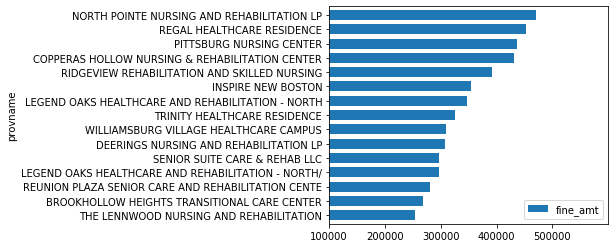

In [38]:
ax2 = most_fines.sort_values(by='fine_amt').plot(x='provname',
                      y='fine_amt',
                      kind='barh',
                      figsize=(5, 4),
                      width=0.7)
ax2.set_xticks([100000, 200000, 300000, 400000, 500000])
ax2.set_xlim(100000,600000)

plt.savefig('nursinghomes5.pdf')

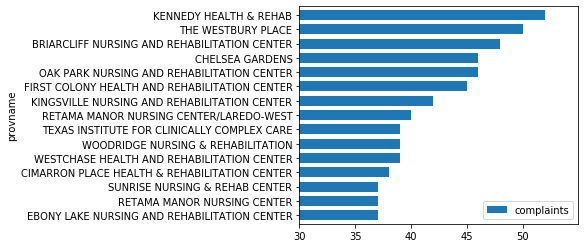

In [39]:
ax = texas_complaints.sort_values(by='complaints').plot(x='provname',
                      y='complaints',
                      kind='barh',
                      figsize=(5, 4),
                      width=0.7)
ax.set_xticks([30, 35, 40, 45, 50])
ax.set_xlim(30,55)

plt.savefig('nursinghomes4.pdf')

## Scatterplot of fines

In [40]:
df3 = pd.read_excel("penaltiestest.xlsx")

In [41]:
df3.head()

,provnum,provname,address,city,zip,scatter,pnlty_date,pnlty_type,fine_amt
0,455929,GRANBURY REHAB & NURSING,2124 PALUXY HWY,GRANBURY,76048,219,2015-08-06,Fine,98
1,675109,THE VILLAGE AT RICHARDSON,1111 ROCKINGHAM LN,RICHARDSON,75080,332,2016-06-16,Fine,195
2,675812,"WHISPERING PINES NURSING AND REHABILITATION, LP",910 S BEECH ST,WINNSBORO,75494,103,2014-09-10,Fine,650
3,675812,"WHISPERING PINES NURSING AND REHABILITATION, LP",910 S BEECH ST,WINNSBORO,75494,103,2014-09-10,Fine,650
4,676028,SOUTHERN SPECIALTY REHAB & NURSING,4320 W 19TH ST,LUBBOCK,79407,125,2014-11-19,Fine,650


In [47]:
df3['pnlty_date'] = pd.to_datetime(df3['pnlty_date'].dropna(), format="%Y-%m-%d")

In [48]:
df3['year'] = pd.DataFrame(pd.DatetimeIndex(df3['pnlty_date']).year)

In [49]:
df3.pnlty_date.value_counts()

2016-05-19    6
2014-06-04    5
2017-05-16    5
2014-10-29    5
2014-02-14    5
             ..
2017-04-26    1
2017-03-07    1
2016-02-09    1
2015-11-02    1
2018-12-21    1
Name: pnlty_date, Length: 734, dtype: int64

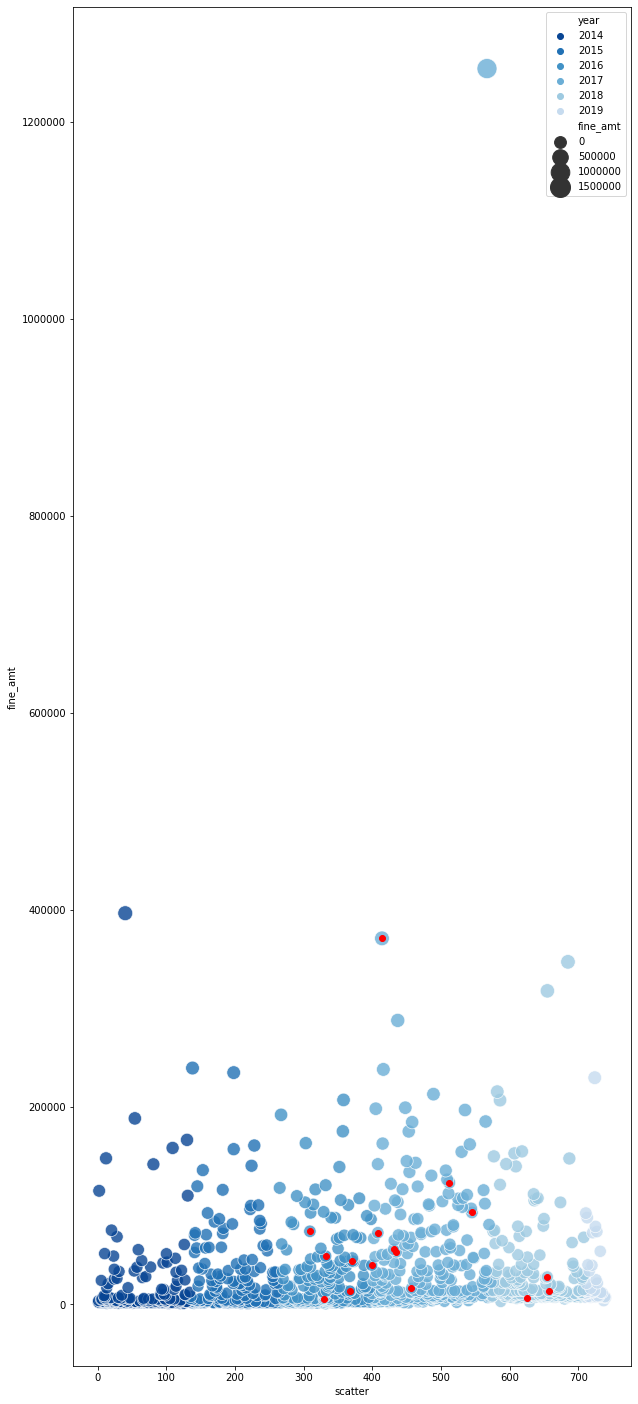

In [51]:
colors = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef']
fig, ax = plt.subplots(figsize=(10, 25))
chart = sns.scatterplot(x='scatter', 
                        y='fine_amt', 
                        size='fine_amt',
                        palette=colors,
                        sizes=(140, 400),
                        hue = 'year',
                        alpha=0.8,
                        data=df3,
                        ax=ax)
plt.scatter(x=655, y=27701, color='r')
plt.scatter(x=512, y=123404, color='r')
plt.scatter(x=545, y=93053, color='r')
plt.scatter(x=309, y=73933, color='r')
plt.scatter(x=408, y= 72508 , color='r')
plt.scatter(x=431, y=55646, color='r')
plt.scatter(x=435, y=53057, color='r')
plt.scatter(x=332, y= 48815 , color='r')
plt.scatter(x=399, y=39550, color='r')
plt.scatter(x=371, y=43692, color='r')
plt.scatter(x=457, y= 16139 , color='r')
plt.scatter(x=658, y=13328, color='r')
plt.scatter(x=368, y=13244, color='r')
plt.scatter(x=625, y=6500, color='r')
plt.scatter(x=329, y=5525, color='r')
plt.scatter(x=414, y=371287, color='r')


#plt.savefig("scatterplot.pdf")

In [52]:
texas_deficiencies.groupby(['city']).scope_severity.count().sort_values(ascending=False)

city
SAN ANTONIO       2119
HOUSTON           1778
FORT WORTH         624
CORPUS CHRISTI     601
EL PASO            556
                  ... 
BERTRAM              4
ALAMO                3
TEAGUE               3
MARLIN               2
MABANK               1
Name: scope_severity, Length: 446, dtype: int64

# Map out cities with most deficiencies

In [53]:
csvforgeocodio = pd.DataFrame(texas_deficiencies.groupby(['address', 'city', 'state', 'zip']).scope_severity.count())

In [54]:
csvforgeocodio = csvforgeocodio.reset_index()

In [55]:
csvforgeocodio.head()

,address,city,state,zip,scope_severity
0,100 GAY ST,MENARD,TX,76859,11
1,100 HERMANN DR,DEL RIO,TX,78840,18
2,100 N E LOOP 304,CROCKETT,TX,75835,11
3,1000 AVE J,LAMPASAS,TX,76550,51
4,1000 E MAIN ST,ROUND ROCK,TX,78664,9


In [56]:
#csvforgeocodio.to_csv('csvforgeocodio.csv', index=False)